# Introduction

The prediction of future global temperatures is a critical aspect of climate research and policy-making. By accurately forecasting temperature trends, we can gain valuable insights into the potential impacts of climate change and make informed decisions to mitigate its effects. In this study, we explore the use of ARIMA (Autoregressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) models to forecast global temperature values based solely on historical temperature data.

The dataset used in this analysis is sourced from Berkeley Earth, an organization affiliated with Lawrence Berkeley National Laboratory. This dataset provides comprehensive and reliable surface temperature measurements from various locations across the globe. The data can be accessed from the following Kaggle repository: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data.

The primary objective of this study is to investigate the effectiveness of ARIMA and SARIMA models in capturing the temporal patterns and predicting future global temperature changes. These models are well-suited for time series analysis, as they can account for the autocorrelation and seasonality present in the temperature data.

By leveraging the historical temperature observations, we aim to develop accurate and robust forecasting models. The insights gained from these models can help us understand the long-term temperature trends, identify potential climate anomalies, and assess the efficacy of climate change mitigation strategies.

# EDA

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dataL

In [2]:
# Importing dataset
df = pd.read_csv('/home/veroastro/Documents/Forecasting_globla_temp/data/GlobalTemperatures.csv')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# creating dataset with the relevant columns and 
    # deleting the missing values
cols = ['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty']
land_avg_temp = df[cols].dropna()
land_avg_temp.isna().sum()

dt                                   0
LandAverageTemperature               0
LandAverageTemperatureUncertainty    0
dtype: int64

In [4]:
# creating the dataset of temperatures by year
land_avg_temp['years'] = pd.DatetimeIndex(land_avg_temp['dt']).year
yearly = land_avg_temp.groupby('years').mean()
print(yearly.describe())


       LandAverageTemperature  LandAverageTemperatureUncertainty
count              266.000000                         266.000000
mean                 8.369337                           0.945719
std                  0.584921                           0.994110
min                  5.779833                           0.062083
25%                  8.081563                           0.210208
50%                  8.372167                           0.405583
75%                  8.704167                           1.629563
max                  9.831000                           4.026000


In [5]:
# Creating the dataset with only the temperatures and 
# dropping first 100 elements to reduce errors.
avg_temp = yearly['LandAverageTemperature'].drop(yearly.index[:100])
avg_temp.describe()

count    166.000000
mean       8.571583
std        0.473687
min        7.558583
25%        8.195708
50%        8.540750
75%        8.791250
max        9.831000
Name: LandAverageTemperature, dtype: float64

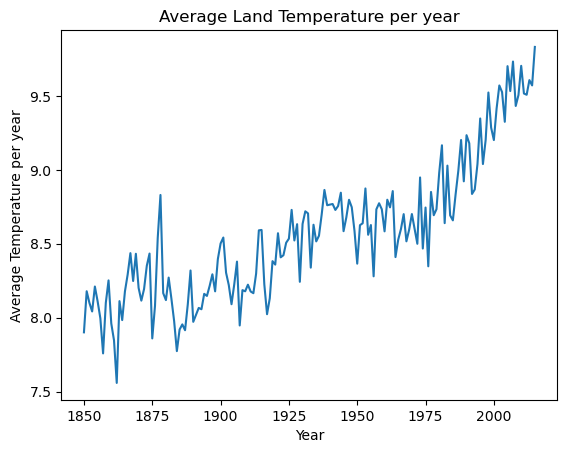

In [6]:
# Plotting the new dataset
y = avg_temp
plt.plot(y)
plt.title("Average Land Temperature per year")
plt.xlabel("Year")
plt.ylabel("Average Temperature per year")
plt.show()


There is less sharp variations on the temperatures. Also the temperature seems to sharply increase since about 1960 of about 1 degree celsius. 

# Analysis

## Data Preprocessing

In [7]:
# splitting the dataset into train and test datasets
size = len(avg_temp)
cutoff = int(size*0.7)
train = pd.DataFrame(avg_temp[:cutoff])
test = pd.DataFrame(avg_temp[cutoff:])
print('train:', train.shape)
print('test:', test.shape)
print('Cut-off year =', 1850+train.shape[0])

train: (116, 1)
test: (50, 1)
Cut-off year = 1966


In [8]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [9]:
lookback = 4
X_train, y_train = create_dataset(train.to_numpy(), lookback=lookback)
X_test, y_test = create_dataset(test.to_numpy(), lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([112, 4, 1]) torch.Size([112, 4, 1])
torch.Size([46, 4, 1]) torch.Size([46, 4, 1])


## Building Model



In [10]:
from sklearn.metrics import mean_squared_error
# Fit the naive model
naive_model_predictions = np.repeat(train.iloc[-1], len(test))

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test, naive_model_predictions))
print(f"RMSE of Naive Model: {rmse:.4f}")

RMSE of Naive Model: 0.6863


In [11]:

class LSTMmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [12]:
model = LSTMmodel().double()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = dataL.DataLoader(dataL.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 

From the plot above, the trend of the dataset has been removed.

In [13]:
n_epochs = 4000 
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 

Epoch 0: train RMSE 7.8400, test RMSE 8.5584
Epoch 100: train RMSE 0.2714, test RMSE 0.7569
Epoch 200: train RMSE 0.2164, test RMSE 0.4982
Epoch 300: train RMSE 0.2124, test RMSE 0.4642
Epoch 400: train RMSE 0.2170, test RMSE 0.4181
Epoch 500: train RMSE 0.2139, test RMSE 0.3946
Epoch 600: train RMSE 0.2041, test RMSE 0.3629
Epoch 700: train RMSE 0.1978, test RMSE 0.3614
Epoch 800: train RMSE 0.1946, test RMSE 0.3443
Epoch 900: train RMSE 0.1927, test RMSE 0.3119
Epoch 1000: train RMSE 0.2042, test RMSE 0.3647
Epoch 1100: train RMSE 0.1916, test RMSE 0.3078
Epoch 1200: train RMSE 0.1932, test RMSE 0.3272
Epoch 1300: train RMSE 0.1916, test RMSE 0.3205
Epoch 1400: train RMSE 0.1977, test RMSE 0.3335
Epoch 1500: train RMSE 0.1951, test RMSE 0.2831
Epoch 1600: train RMSE 0.1909, test RMSE 0.3011
Epoch 1700: train RMSE 0.1937, test RMSE 0.2898
Epoch 1800: train RMSE 0.1912, test RMSE 0.3047
Epoch 1900: train RMSE 0.1911, test RMSE 0.2910
Epoch 2000: train RMSE 0.1916, test RMSE 0.3126
Epoc

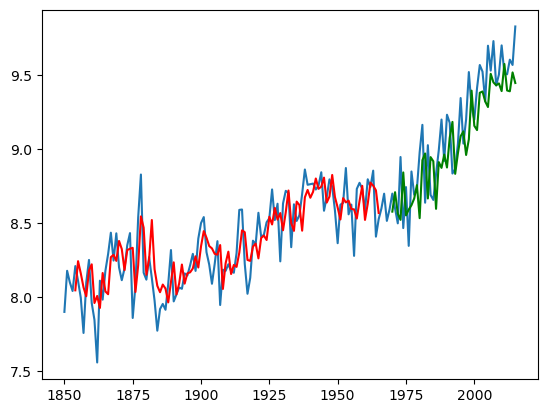

In [14]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(avg_temp) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_pred = np.resize(model(X_train)[:, -1, :].numpy(),112)
    train_plot[lookback:cutoff] = train_pred
    # shift test predictions for plotting
    test_plot = np.ones_like(avg_temp) * np.nan
    test_pred = np.resize(model(X_test)[:, -1, :],46)
    test_plot[cutoff+lookback:len(avg_temp)] = test_pred
# plot
x_axis = np.arange(train.shape[0] + test.shape[0])
x_years = x_axis + 1850  # Year starts at 1850
plt.plot(avg_temp)
plt.plot(x_years,train_plot, c='r')
plt.plot(x_years,test_plot, c='g')
plt.show()


In [15]:

 with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("train RMSE %.4f, test RMSE %.4f" % (train_rmse, test_rmse))
 

train RMSE 0.1903, test RMSE 0.2840


## Optimizing the model

In [30]:
import optuna
from optuna.trial import TrialState
def get_loader(data, batchsize):
    # 
    size = len(data)
    cutoff = int(size*0.8)

    train = pd.DataFrame(data[:cutoff])
    val= pd.DataFrame(data[cutoff:])

    X_train, y_train = create_dataset(train.to_numpy(), lookback=lookback)
    X_val, y_val= create_dataset(val.to_numpy(), lookback=lookback)
    
    train_loader = dataL.DataLoader(dataL.TensorDataset(X_train, y_train), shuffle=True, 
                                    batch_size=batchsize)
    
    valid_loader =  dataL.DataLoader(dataL.TensorDataset(X_val, y_val),
                                        batch_size=batchsize, shuffle=True,)
    
    return train_loader, valid_loader

def calculate_rmse(model, loader):
    predictions = []
    targets = []
    for X, y in loader:
        y_pred = model(X)
        predictions.append(y_pred)
        targets.append(y)

    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    rmse = torch.sqrt(loss_fn(predictions, targets))
    return rmse.item()


def objective(trial):
    model = LSTMmodel().double()
    optimizer_name = optim.Adam(model.parameters())#trial.suggest_categorical("optimizer", ["adam", "SGD", "RMSprop", "Adadelta"])
    epochs = trial.suggest_int("epochs", 1000, 4000,step=100, log=False)
    batchsize = 8 #trial.suggest_int("batchsize", 8, 40,step=16, log=False)
    
    
    train_loader, valid_loader = get_loader(train, batchsize)
                                  
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # Validation

        model.eval()
        with torch.no_grad():
            valid_rmse = calculate_rmse(model, valid_loader)
            
    weights = list(model.named_parameters())

    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    trial.set_user_attr(key="best_model_weights", value=weights)
    return valid_rmse

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model_weights", 
                            value=trial.user_attrs["best_model_weights"])

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, timeout=None, callbacks=[callback])
    
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-06-10 11:05:26,016] A new study created in memory with name: no-name-75ef6c7d-b37a-463b-94aa-cc9fe106f2c2
[I 2023-06-10 11:06:42,297] Trial 0 finished with value: 8.581486241159814 and parameters: {'epochs': 2100}. Best is trial 0 with value: 8.581486241159814.
[I 2023-06-10 11:09:14,297] Trial 1 finished with value: 8.298732663133913 and parameters: {'epochs': 3900}. Best is trial 1 with value: 8.298732663133913.
[I 2023-06-10 11:10:40,401] Trial 2 finished with value: 8.491805702113833 and parameters: {'epochs': 2400}. Best is trial 1 with value: 8.298732663133913.
[I 2023-06-10 11:11:55,948] Trial 3 finished with value: 8.839700400679286 and parameters: {'epochs': 2100}. Best is trial 1 with value: 8.298732663133913.
[I 2023-06-10 11:14:22,592] Trial 4 finished with value: 8.67638985371686 and parameters: {'epochs': 3800}. Best is trial 1 with value: 8.298732663133913.
[I 2023-06-10 11:15:52,664] Trial 5 finished with value: 8.59126209609508 and parameters: {'epochs': 2500}.

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  8.298732663133913
  Params: 
    epochs: 3900
